# WeatherPy

---

## Starter Code to Generate Random Geographic Coordinates and a List of Cities

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import scipy.stats as st
from scipy.stats import linregress

# Impor the OpenWeatherMap API key
from api_keys import weather_api_key
from api_keys import geoapify_api_key

# Import citipy to determine the cities based on latitude and longitude
from citipy import citipy

### Generate the Cities List by Using the `citipy` Library

In [2]:
# Empty list for holding the latitude and longitude combinations
lat_lngs = []

# Empty list for holding the cities names
cities = []

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
print(f"Number of cities in the list: {len(cities)}")

Number of cities in the list: 602


---

## Requirement 1: Create Plots to Showcase the Relationship Between Weather Variables and Latitude

### Use the OpenWeatherMap API to retrieve weather data from the cities list generated in the started code

In [3]:
# set base url
baseweatherUrl = "http://api.openweathermap.org/data/2.5/"
basegeoUrl = "https://api.geoapify.com/v2/"

weatherKey = weather_api_key
geoKey = geoapify_api_key

# def getCityUrl(city, apikey):
#     result = f"https://api.geoapify.com/v1/geocode/search?apiKey={apikey}&format=json&text={city}&type=city"
#     return result

# def getWeatherUrl(lat, lon, apikey):
#     result = f"{baseweatherUrl}weather?appid={apikey}&units=imperial&q={city}"
#     return result

def getCityWeatherUrl(city, apikey):
    result = f"{baseweatherUrl}weather?appid={apikey}&units=imperial&q={city}"
    return result


### City Data

In [6]:
# Define an empty list to fetch the weather data for each city
city_data = []

# Print to output
print("Beginning Data Retrieval     ")
print("-----------------------------")

# Create counters
record_count = 1
set_count = 1

# Loop through all the cities in our list to fetch weather data
for i, city in enumerate(cities):
        
    # Group cities in sets of 50 for logging purposes
    if (i % 50 == 0 and i >= 50):
        set_count += 1
        record_count = 0

    # Create endpoint URL with each city
    city_url = getCityUrl(city,geoKey)
        
    # get weather endpoint
    weatherUrl = getCityWeatherUrl(city, weatherKey)
    
    # Log the url, record, and set numbers
    print("Processing Record %s of Set %s | %s" % (record_count, set_count, city))

    # Add 1 to the record count
    record_count += 1

    # Run an API request for each of the cities
    try:
        # Parse the JSON and retrieve data
        cityData = requests.get(city_url).json()
        weatherData = requests.get(weatherUrl).json()

        city_weather = weatherData["main"]["temp"]

        # Parse out latitude, longitude, max temp, humidity, cloudiness, wind speed, country, and date
        city_lat = weatherData["coord"]["lat"]
        city_lng = weatherData["coord"]["lon"]
        city_max_temp = weatherData["main"]["temp_max"]
        city_humidity = weatherData["main"]["humidity"]
        city_clouds = weatherData["clouds"]["all"]
        city_wind = weatherData["wind"]["speed"]
        city_country = cityData["results"][0]["country"]
        city_date = weatherData["dt"]

        # Append the City information into city_data list
        city_data.append({"City": city, 
                          "Lat": city_lat, 
                          "Lng": city_lng, 
                          "Weather": city_weather,
                          "Max Temp": city_max_temp,
                          "Humidity": city_humidity,
                          "Cloudiness": city_clouds,
                          "Wind Speed": city_wind,
                          "Country": city_country,
                          "Date": city_date})

    # If an error is experienced, skip the city
    except:
        print(f"City '{city}' not found. Skipping...")
        pass
              
# Indicate that Data Loading is complete 
print("-----------------------------")
print("Data Retrieval Complete      ")
print("-----------------------------")

Beginning Data Retrieval     
-----------------------------
Processing Record 1 of Set 1 | dunedin
Processing Record 2 of Set 1 | codrington
Processing Record 3 of Set 1 | whitehorse
Processing Record 4 of Set 1 | udachny
Processing Record 5 of Set 1 | port-aux-francais
City 'port-aux-francais' not found. Skipping...
Processing Record 6 of Set 1 | pangody
Processing Record 7 of Set 1 | college
Processing Record 8 of Set 1 | west island
Processing Record 9 of Set 1 | sokcho
Processing Record 10 of Set 1 | phan rang-thap cham
Processing Record 11 of Set 1 | taiohae
City 'taiohae' not found. Skipping...
Processing Record 12 of Set 1 | jamestown
Processing Record 13 of Set 1 | hasaki
Processing Record 14 of Set 1 | mount gambier
Processing Record 15 of Set 1 | bilibino
Processing Record 16 of Set 1 | adamstown
Processing Record 17 of Set 1 | kununurra
Processing Record 18 of Set 1 | utrik
Processing Record 19 of Set 1 | port lincoln
Processing Record 20 of Set 1 | yuzhno-kurilsk
Processing

### Latitude vs. Temperature

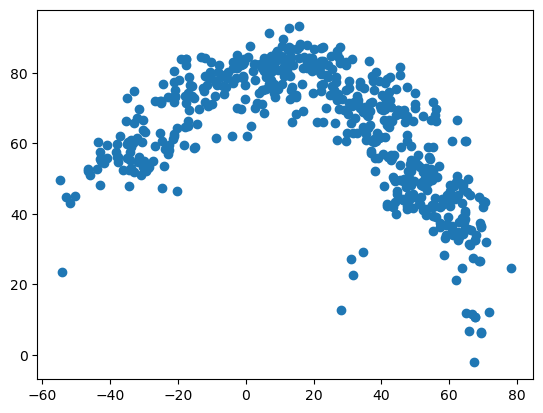

In [7]:
# define dataframe for city data and show scatter plot
city_data_df = pd.DataFrame(city_data)
city_data_df

plt.scatter(city_data_df["Lat"],city_data_df["Max Temp"])

plt.show()

plt.close()


### Latitude vs. Humidity

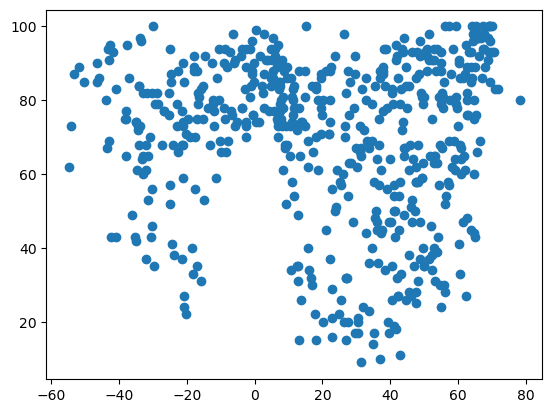

In [8]:
# show scatter plot
plt.scatter(city_data_df["Lat"],city_data_df["Humidity"])

plt.show()

plt.close()

### Latitude vs. Cloudiness

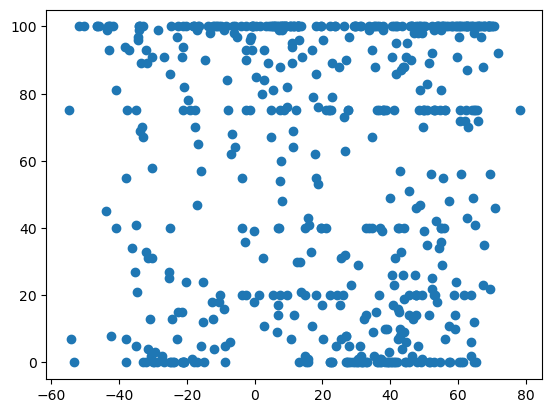

In [9]:
plt.scatter(city_data_df["Lat"],city_data_df["Cloudiness"])

plt.show()

plt.close()

### Latitude vs. Wind Speed

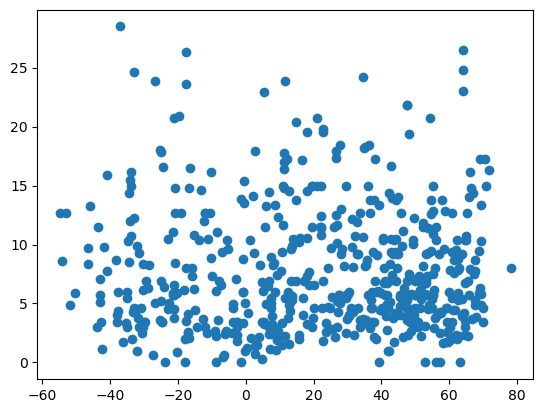

In [10]:
plt.scatter(city_data_df["Lat"],city_data_df["Wind Speed"])

plt.show()

plt.close()

---

## Requirement 2: Compute Linear Regression for Each Relationship

In [11]:
# create northern and southern hemisphere dataframes
north_hemisphere = city_data_df.loc[city_data_df["Lat"] >= 0]
south_hemisphere = city_data_df.loc[city_data_df["Lat"] <= 0]

In [12]:
# create a function for regression scatter plot
def getLinearRegression(x,y):
    print(f"The r-value is: {round(st.pearsonr(x,y)[0],2)}")
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x,y)
    regress = x * slope + intercept
    result = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    plt.scatter(x,y)
    plt.plot(x,regress,color='r',alpha=0.7)
    return result

def annotation(regress, left, top):
    plt.annotate(regress,(left,top),fontsize=12,color="red")


###  Temperature vs. Latitude Linear Regression Plot

The r-value is: -0.82


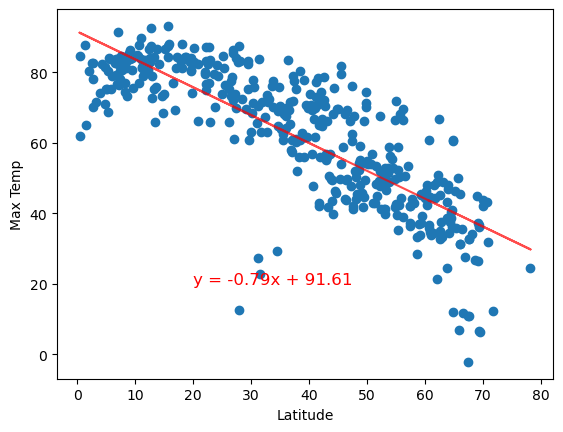

In [13]:
# Linear regression on Northern Hemisphere
x_val = north_hemisphere["Lat"]
y_val = north_hemisphere["Max Temp"]
eq = getLinearRegression(x_val, y_val)

annotation(eq, 20, 20)

plt.xlabel("Latitude")
plt.ylabel("Max Temp")
plt.show()

plt.close()

The r-value is: 0.8


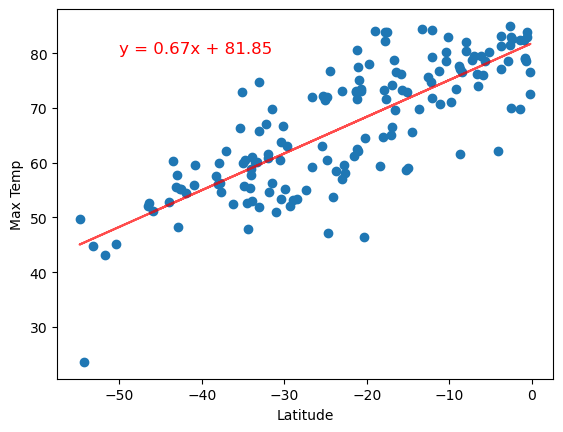

In [14]:
# Linear regression on Southern Hemisphere
x_val = south_hemisphere["Lat"]
y_val = south_hemisphere["Max Temp"]
eq = getLinearRegression(x_val, y_val)

annotation(eq, -50, 80)

plt.xlabel("Latitude")
plt.ylabel("Max Temp")
plt.show()

plt.close()

There is a strong negative correlation and positive correlation between latitude and max temperature for northern and southern hemispheres respectively.

### Humidity vs. Latitude Linear Regression Plot

The r-value is: 0.07


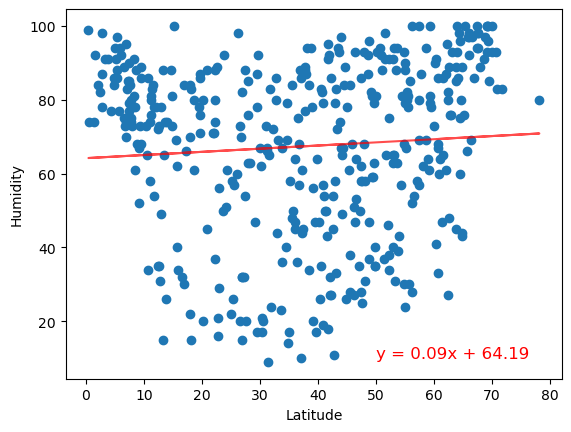

In [15]:
# Northern Hemisphere
x_val = north_hemisphere["Lat"]
y_val = north_hemisphere["Humidity"]
eq = getLinearRegression(x_val, y_val)

annotation(eq, 50, 10)

plt.xlabel("Latitude")
plt.ylabel("Humidity")
plt.show()

plt.close()

The r-value is: 0.15


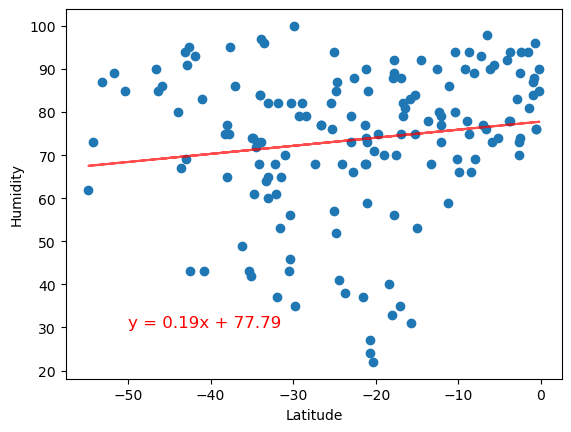

In [16]:
# Southern Hemisphere
x_val = south_hemisphere["Lat"]
y_val = south_hemisphere["Humidity"]
eq = getLinearRegression(x_val, y_val)

annotation(eq, -50, 30)

plt.xlabel("Latitude")
plt.ylabel("Humidity")
plt.show()

plt.close()

There is a weak and moderate correlation between latitude and humidity for northern and southern hemispheres.

### Cloudiness vs. Latitude Linear Regression Plot

The r-value is: 0.01


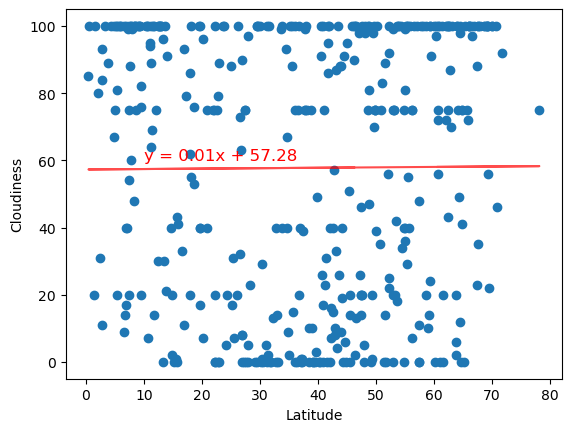

In [17]:
# Northern Hemisphere
x_val = north_hemisphere["Lat"]
y_val = north_hemisphere["Cloudiness"]
eq = getLinearRegression(x_val, y_val)

annotation(eq, 10, 60)

plt.xlabel("Latitude")
plt.ylabel("Cloudiness")
plt.show()

plt.close()

The r-value is: 0.06


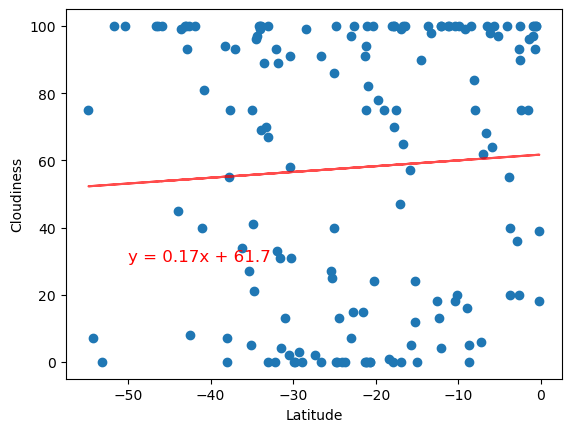

In [18]:
# Southern Hemisphere
x_val = south_hemisphere["Lat"]
y_val = south_hemisphere["Cloudiness"]
eq = getLinearRegression(x_val, y_val)

annotation(eq, -50, 30)

plt.xlabel("Latitude")
plt.ylabel("Cloudiness")
plt.show()

plt.close()

There is a weak and moderate correlation between latitude and cloudiness for northern and southern hemispheres.

### Wind Speed vs. Latitude Linear Regression Plot

The r-value is: -0.0


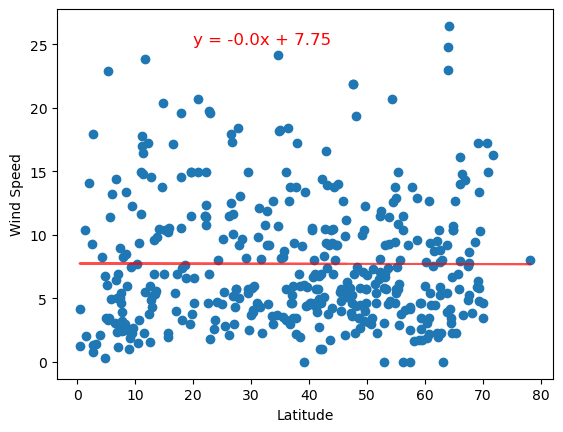

In [19]:
# Northern Hemisphere
x_val = north_hemisphere["Lat"]
y_val = north_hemisphere["Wind Speed"]
eq = getLinearRegression(x_val, y_val)

annotation(eq, 20, 25)

plt.xlabel("Latitude")
plt.ylabel("Wind Speed")
plt.show()

plt.close()

The r-value is: -0.13


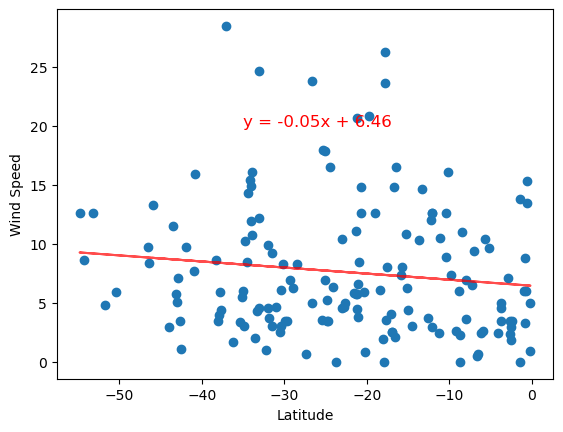

In [20]:
# Southern Hemisphere
x_val = south_hemisphere["Lat"]
y_val = south_hemisphere["Wind Speed"]
eq = getLinearRegression(x_val, y_val)

annotation(eq, -35, 20)

plt.xlabel("Latitude")
plt.ylabel("Wind Speed")
plt.show()

plt.close()

There is a weak negative correlation between latitude and wind speed for northern and southern hemispheres.